In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

# ----------------------------------
# 1. 초기 참여자 정보 생성
# ----------------------------------
n = 10000
np.random.seed(0)

base_df = pd.DataFrame({
    "id": np.arange(n),
    "성별": np.random.choice(["남", "여"], size=n, p=[0.462, 0.538]),
    "연령대": np.random.choice(["20대", "30대", "40대", "50대", "60대"], size=n,
                            p=[0.0505, 0.2478, 0.3583, 0.2841, 0.0593]),
    "학력": np.random.choice(["고졸", "대졸", "대학원"], size=n, p=[0.29, 0.61, 0.1]),
    "초기 실천수": np.random.choice([0, 1, 2, 3, 4, 5], size=n,
                                 p=[0.1411, 0.2768, 0.3106, 0.1904, 0.0686, 0.0125]),
    "초기 건강위험요인 수": np.random.choice([0, 1, 2, 3, 4, 5], size=n,
                               p=[0.0435, 0.1692, 0.2824, 0.264, 0.1577, 0.0832])
})

# ----------------------------------
# 2. 3개월차 상태 시뮬레이션
# ----------------------------------
np.random.seed(0)
behavior_increase_3 = np.random.rand(n) < 0.4271
behavior_improve_3 = np.random.rand(n) < 0.4575
risk_reduction_3 = np.random.rand(n) < 0.5325

reduction_probs_3 = np.array([0.3390, 0.1461, 0.0474])
reduction_probs_3 /= reduction_probs_3.sum()

behavior_now_3 = []
risk_now_3 = []

for i in range(n):
    val = base_df.loc[i, "초기 실천수"]
    if behavior_increase_3[i]:
        val -= np.random.choice([1, 2, 3], p=[0.7, 0.2, 0.1])
    behavior_now_3.append(np.clip(val, 0, 5))

    val_r = base_df.loc[i, "초기 건강위험요인 수"]
    if risk_reduction_3[i]:
        val_r += np.random.choice([1, 2, 3], p=reduction_probs_3)
    risk_now_3.append(np.clip(val_r, 0, 5))

# ----------------------------------
# 3. 3개월차 만족도 및 churn
# ----------------------------------
mean_std_dict = {
    "전반적 만족도": (4.32, 0.74),
    "습관개선 도움정도": (4.23, 0.73),
    "내용 이해도": (4.09, 0.78),
    "관심도": (4.20, 0.72),
    "타인 권유": (4.30, 0.70),
    "총점": (4.23, 0.62)
}

def simulate_score(mean, std, n, clip=(1.0, 5.0)):
    return np.clip(np.random.normal(loc=mean, scale=std, size=n), *clip)

df_satisfaction_3 = pd.DataFrame({
    "전반적 만족도": simulate_score(*mean_std_dict["전반적 만족도"], n),
    "습관개선 도움정도": simulate_score(*mean_std_dict["습관개선 도움정도"], n),
    "내용 이해도": simulate_score(*mean_std_dict["내용 이해도"], n),
    "관심도": simulate_score(*mean_std_dict["관심도"], n),
    "타인 권유": simulate_score(*mean_std_dict["타인 권유"], n),
})
df_satisfaction_3["총점"] = simulate_score(*mean_std_dict["총점"], n)
df_satisfaction_3["백분위 환산"] = (df_satisfaction_3["총점"] / 5) * 100
cutoff = norm.ppf(0.0667, loc=4.23, scale=0.62)
df_satisfaction_3["churn"] = (df_satisfaction_3["총점"] <= cutoff).astype(int)

# ----------------------------------
# 4. 3개월차 통합
# ----------------------------------
df_3month = pd.concat([
    base_df[["성별", "연령대", "학력", "초기 실천수", "초기 건강위험요인 수"]],
    pd.DataFrame({
        "건강행태 실천수(단위:개)": behavior_now_3,
        "건강위험요인 수(단위:개)": risk_now_3,
        "3개월차 실천 증가자": behavior_increase_3,
        "3개월차 실천 개선자": behavior_improve_3,
        "3개월차 위험요인 감소자": risk_reduction_3
    }),
    df_satisfaction_3
], axis=1)

# ----------------------------------
# 5. 6개월차 상태 시뮬레이션
# ----------------------------------
np.random.seed(1)
behavior_increase_6 = np.random.rand(n) < 0.5233
behavior_improve_6 = np.random.rand(n) < 0.5348
risk_reduction_6 = np.random.rand(n) < 0.6302

reduction_probs_6 = np.array([0.3614, 0.1867, 0.0821])
reduction_probs_6 /= reduction_probs_6.sum()

behavior_now_6 = []
risk_now_6 = []

for i in range(n):
    val = df_3month.loc[i, "건강행태 실천수(단위:개)"]
    if behavior_increase_6[i]:
        val -= np.random.choice([1, 2, 3], p=[0.7, 0.2, 0.1])
    behavior_now_6.append(np.clip(val, 0, 5))

    val_r = df_3month.loc[i, "건강위험요인 수(단위:개)"]
    if risk_reduction_6[i]:
        val_r += np.random.choice([1, 2, 3], p=reduction_probs_6)
    risk_now_6.append(np.clip(val_r, 0, 5))

# ----------------------------------
# 6. 6개월차 만족도 및 churn
# ----------------------------------
df_satisfaction_6 = pd.DataFrame({
    "전반적 만족도": simulate_score(*mean_std_dict["전반적 만족도"], n),
    "습관개선 도움정도": simulate_score(*mean_std_dict["습관개선 도움정도"], n),
    "내용 이해도": simulate_score(*mean_std_dict["내용 이해도"], n),
    "관심도": simulate_score(*mean_std_dict["관심도"], n),
    "타인 권유": simulate_score(*mean_std_dict["타인 권유"], n),
})
df_satisfaction_6["총점"] = simulate_score(*mean_std_dict["총점"], n)
df_satisfaction_6["백분위 환산"] = (df_satisfaction_6["총점"] / 5) * 100
df_satisfaction_6["churn"] = (df_satisfaction_6["총점"] <= cutoff).astype(int)

# ----------------------------------
# 7. 6개월차 통합 (초기 정보 포함)
# ----------------------------------
df_6month_final = pd.concat([
    base_df[["성별", "연령대", "학력", "초기 실천수", "초기 건강위험요인 수"]],
    pd.DataFrame({
        "건강행태 실천수(단위:개)": behavior_now_6,
        "건강위험요인 수(단위:개)": risk_now_6,
        "6개월차 실천 증가자": behavior_increase_6,
        "6개월차 실천 개선자": behavior_improve_6,
        "6개월차 위험요인 감소자": risk_reduction_6
    }),
    df_satisfaction_6
], axis=1)

# ----------------------------------
# 8. 출력
# ----------------------------------


In [3]:
print("✅ [3개월차 결과]")
print(df_3month.head(3))




✅ [3개월차 결과]
  성별  연령대   학력  초기 실천수  초기 건강위험요인 수  건강행태 실천수(단위:개)  건강위험요인 수(단위:개)  3개월차 실천 증가자  3개월차 실천 개선자  3개월차 위험요인 감소자   전반적 만족도  습관개선 도움정도    내용 이해도       관심도     타인 권유        총점      백분위 환산  churn
0  여  50대   대졸       3            2               3               4        False        False           True  3.928919   4.787518  3.447643  4.430602  4.233263  5.000000  100.000000      0
1  여  30대   고졸       2            1               2               2        False         True           True  5.000000   5.000000  3.773320  4.331083  4.068253  4.767162   95.343239      0
2  여  40대  대학원       1            2               1               2        False         True          False  4.466564   4.115076  3.772819  4.123800  5.000000  3.579434   71.588689      0


In [4]:
print("\n✅ [6개월차 결과]")
print(df_6month_final.head(3))


✅ [6개월차 결과]
  성별  연령대   학력  초기 실천수  초기 건강위험요인 수  건강행태 실천수(단위:개)  건강위험요인 수(단위:개)  6개월차 실천 증가자  6개월차 실천 개선자  6개월차 위험요인 감소자   전반적 만족도  습관개선 도움정도    내용 이해도       관심도    타인 권유        총점      백분위 환산  churn
0  여  50대   대졸       3            2               2               4         True        False          False  4.913136   3.774748  4.579216  4.410501  4.16552  5.000000  100.000000      0
1  여  30대   고졸       2            1               2               5        False         True           True  5.000000   3.942518  4.756976  4.025129  5.00000  4.987792   99.755836      0
2  여  40대  대학원       1            2               0               2         True        False          False  4.336698   4.536924  2.976362  4.279859  5.00000  3.906069   78.121384      0


In [5]:
# 3개월차 결과 저장
df_3month.to_csv("3개월차_데이터.csv", index=False, encoding='utf-8-sig')

# 6개월차 결과 저장
df_6month_final.to_csv("6개월차_데이터.csv", index=False, encoding='utf-8-sig')

# (선택) 초기 참여자 정보 저장
base_df.to_csv("초기참여자_데이터.csv", index=False, encoding='utf-8-sig')

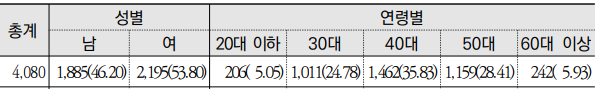 - 연령별 참여 인원수에 대한 백분율

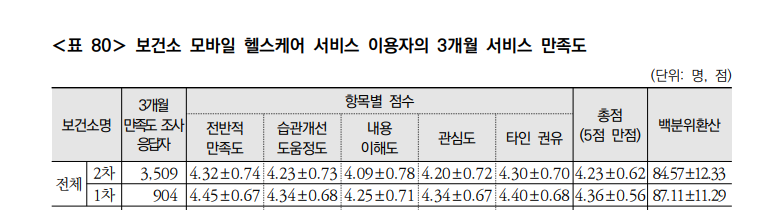
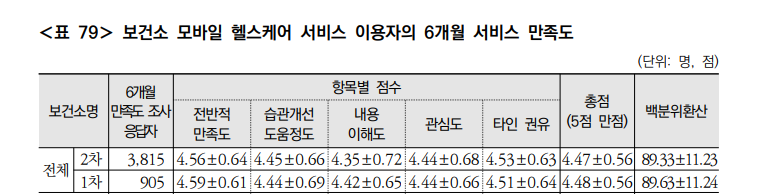
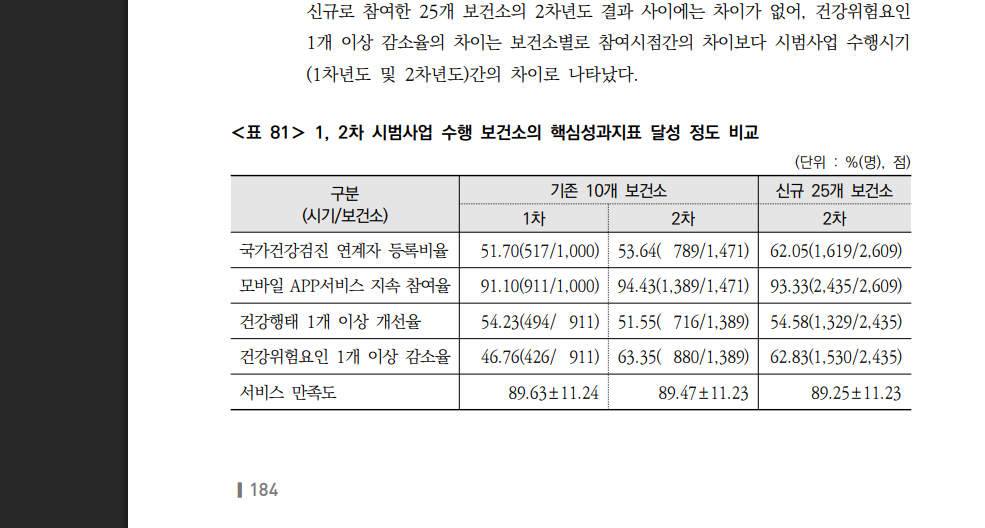

chrun 값을 구하는데 사용한 자료